# Route Algorithm: The Electric Vehicle Routing Problem

In this notebook we will analyze and solve the Electric Vehicle Routing Problem (EVRP) which asks the question:"How to travel from $A$ to $B$, including mandatory charging stops along the way, in the shortest time possible". This will be done using mathematical graph theory and Mixed Integer Linear Programming (MILP) formulation. Moreover, to mimic realistic conditions, the charging curves of the electric vehicle's battery is included in the model.

To solve the model we use CPLEX, an optimization package to solve mathematical programming problems. 

During the time optimization of the model, the solver takes decisions on which is the best charging columns to use and on how much energy to charge in order to reach the final destination in the shortest time.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Graph-Representation-of-the-EVRP" data-toc-modified-id="Graph-Representation-of-the-EVRP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Graph Representation of the EVRP</a></span></li><li><span><a href="#Mixed-Integer-Linear-Programming" data-toc-modified-id="Mixed-Integer-Linear-Programming-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mixed Integer Linear Programming</a></span><ul class="toc-item"><li><span><a href="#Mathematical-Formulation-of-the-EVRP" data-toc-modified-id="Mathematical-Formulation-of-the-EVRP-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Mathematical Formulation of the EVRP</a></span><ul class="toc-item"><li><span><a href="#Objective-Function" data-toc-modified-id="Objective-Function-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Objective Function</a></span></li><li><span><a href="#Constraints" data-toc-modified-id="Constraints-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Constraints</a></span></li><li><span><a href="#Charging-Time" data-toc-modified-id="Charging-Time-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Charging Time</a></span></li></ul></li><li><span><a href="#Adding-Charging-Curves" data-toc-modified-id="Adding-Charging-Curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Adding Charging Curves</a></span></li></ul></li><li><span><a href="#CPLEX-Limitations" data-toc-modified-id="CPLEX-Limitations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CPLEX Limitations</a></span></li><li><span><a href="#Possible-Implementation" data-toc-modified-id="Possible-Implementation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Possible Implementation</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

Routing problems are those in which a person or vehicle is asked to accomplish a given route in the most efficient way. The Most famous of these problems is the Traveling salesman problem or [TSP](https://en.wikipedia.org/wiki/Travelling_salesman_problem) which asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?" 

![TSP](https://camo.githubusercontent.com/0e04242412216ab72559bd8484c2cec179c41a4f/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a6279334d67646b6d616d4541786c43614948363858672e6a706567)
<center>
    <b>Fig 1.</b> Traveling salesman problem. 
    From: https://github.com/enzoftware/traveling_salesman       
</center>

In our particular case, we have an electric vehicle and we want to travel, in the shortest time possible, from an origin point $O$ to a final destination $D$ which is located $X$ km away. However, the driving range of the electric vehicle (EV) is constrained by its battery capacity and state of charge (SoC). This means, that if $X$ is larger than the driving range of the EV at a given SoC, detours to charging stations are required in order to accomplish the total route. This EV Routing Problem can then be rephrased as: 
    
"Given a route from origin $O$ to destination $D$ and the location of $S$ charge stations along the route, and taking into account the drive range and SoC of the EV, which charge stations do I need to use and how much do I need to recharge my EV in order to reach the final destination in the shortest time?"
    
## Graph Representation of the EVRP
    
Routing problems can be mathematically modeled as [Graphs](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)), where the origin, destination and the charging stations are the vertices or nodes of the graph, whereas the paths between nodes are the arcs or edges of the graph.

Lets consider as an example, the hypothetical route shown in the figure below. Here we want to travel from $O$ to $D$ and we have $S_i$ charge stations (green points) along the route. Here $O$, $D$ and $S_i$ are the nodes and the blue lines are the arcs of the graph. 

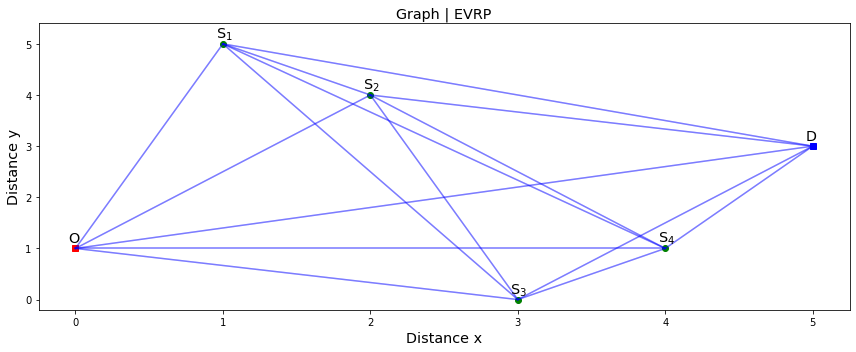

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import pwlf
import pandas as pd

n_cs = 4 # number of charge stations
stations = [n+1 for n in range(n_cs)] #cs nodes
nodes = [0]+stations
destination = len(nodes)
nodes.append(destination) # append destination node to nodes
rnd.seed(10)
loc_x = np.array([n for n in range(n_cs+2)])
loc_y = np.array([rnd.randint(0,6) for n in range(n_cs+2)])

arcs = [(i,j) for i in nodes for j in nodes if i!=j]

#plot nodes
plt.figure(figsize=(12,5))
plt.plot(loc_x[stations], loc_y[stations], 'o', color='green')
plt.plot(loc_x[0], loc_y[0], 'o', marker='s',color='red')
plt.plot(loc_x[destination], loc_y[destination], 'o', marker='s',c='blue')
for i in nodes:
    for j in nodes:
        if i!=j:
            plt.plot(loc_x[[i,j]], loc_y[[i,j]], '-', c='blue', alpha=0.3)

for i in stations:
    plt.annotate(r'S$_{{{}}}$'.format(i), (loc_x[i]-.05, loc_y[i]+.12), fontsize='x-large')
plt.annotate('O', (loc_x[0]-.05, loc_y[0]+.12), fontsize='x-large')
plt.annotate('D', (loc_x[destination]-.05, loc_y[destination]+.12), fontsize='x-large')
plt.ylim(-.2,5.4)
plt.xlabel('Distance x', fontsize='x-large')
plt.ylabel('Distance y', fontsize='x-large')
plt.title('Graph | EVRP', fontsize='x-large')
plt.tight_layout()

These arcs show all possible connections between nodes. We can add attributes to the graph in terms of the arcs, for instance for a given arc we can define a dimension $d_{i,j}$ representing the distance between node $i$ and $j$. In this way we can have a distance matrix for the graph as follows:

In [2]:
distance_matrix = [['d({},{})'.format(i,j) if i!=j  else 0 for j in nodes] for i in nodes]
cols = ['O']+['S{}'.format(i) for i in stations]+['D']
dm = pd.DataFrame(distance_matrix, columns=cols, index=cols)
dm

O      S1      S2      S3      S4       D
O        0  d(0,1)  d(0,2)  d(0,3)  d(0,4)  d(0,5)
S1  d(1,0)       0  d(1,2)  d(1,3)  d(1,4)  d(1,5)
S2  d(2,0)  d(2,1)       0  d(2,3)  d(2,4)  d(2,5)
S3  d(3,0)  d(3,1)  d(3,2)       0  d(3,4)  d(3,5)
S4  d(4,0)  d(4,1)  d(4,2)  d(4,3)       0  d(4,5)
D   d(5,0)  d(5,1)  d(5,2)  d(5,3)  d(5,4)       0

Note that when $i=j$, $d=0$ since the distance from one location to itself is zero. 

In the same way, one can define other attributes like travel time between nodes, energy consumption, etc.

For our particular case, since we don't want to return to the initial point $O$, we can simplify our problem by considering only the arcs corresponding to those displacements in the direction towards the final destination $D$. This is, we do not consider arcs that represent a displacement to a node that we have visited already (i.e., $i<j$) or to itself (i.e., $i\ne j$). This is what is known as an acyclic directed graph. 

In this case, our distance matrix will look like this:

In [3]:
distance_matrix = [['d({},{})'.format(i,j) if i!=j and i<j  else '' for j in nodes] for i in nodes]
cols = ['O']+['S{}'.format(i) for i in stations]+['D']
dm = pd.DataFrame(distance_matrix, columns=cols, index=cols)
dm

O      S1      S2      S3      S4       D
O     d(0,1)  d(0,2)  d(0,3)  d(0,4)  d(0,5)
S1            d(1,2)  d(1,3)  d(1,4)  d(1,5)
S2                    d(2,3)  d(2,4)  d(2,5)
S3                            d(3,4)  d(3,5)
S4                                    d(4,5)
D

Now that we know how to mathematically model our routing problem, lets have a look how can we answer the question: "Which charge stations to use in order to reach my destination in the shortest time".

## Mixed Integer Linear Programming

Since our goal is to find the combination of charging stations that will bring us to the final destination in the shortest time, this is an optimization problem. 

[Linear programming](https://en.wikipedia.org/wiki/Linear_programming) (LP, also called linear optimization) is a method to achieve the best outcome (such as maximum profit or lowest cost) in a mathematical model whose requirements are represented by linear relationships.

More formally, linear programming is a technique for the optimization of a linear objective function, subject to linear equality and linear inequality constraints. A linear programming algorithm finds a point in parameter space where the objective function has the smallest (or largest) value if such a point exists.

Linear programs are problems that can be expressed in canonical form as

$${\begin{aligned}&{\text{Maximize}}&&\mathbf {c}^{\mathrm {T} }\mathbf {x} \\&{\text{subject to}}&&A\mathbf {x} \leq \mathbf {b} \\&{\text{and}}&&\mathbf {x} \geq \mathbf {0} \end{aligned}}$$

where $\mathbf {x}$ represents the vector of variables (to be determined), $\mathbf {c}$ and $\mathbf {b}$ are vectors of (known) coefficients, $A$ is a (known) matrix of coefficients, and $(\cdot )^{\mathrm {T}}$ is the matrix transpose. The expression to be maximized or minimized is called the objective function ($\mathbf {c}^T \mathbf {x}$ in this case). The inequalities $A\mathbf {x} \leq \mathbf {b}$ and $\mathbf {x} \geq 0$ are the constraints which specify a convex parameter space over which the objective function is to be optimized. 

If all the variables are restricted to be integers, then it is said that this refers to an Integer Programming problem. If some decision variables are not discrete the problem is known as a mixed-integer programming problem.

Note that, the term programming does not refer to software programming or code writing, but to task assignment. This is, to program or to order a series of tasks. 

To solve the MILP problem we will use [CPLEX](http://ibmdecisionoptimization.github.io/docplex-doc/), an optimization tool developed by IBM. This uses several optimization algorithms and methods to solve linear programming problems such as Primal Simplex, Dual Simplex, Barrier Optimization, Branch and Bound and Dynamic Search.

### Mathematical Formulation of the EVRP

Let us now consider a case in which we have an EV with a Battery $Q$ with a given energy capacity that travels an hypothetical route from $O$ to $D$. This route is energetically infeasible, that means that the EV needs to charge at different Charge Stations $S_i$ before reaching $D$. To model this scenario we will consider a flow network graph where each arc has a capacity $q_{ij}$ representing the energy required to drive from node $i$ to node $j$. Since the limitation of an EV to travel from $i$ to $j$ is the energy stored in its battery, this capacity $q_{ij}$ will work as a decision variable to choose which path to take as $q_{ij}$ must be smaller or equal to the energy stored in the battery, otherwise, we will not reach node $j$.

As a first approximation, we will consider that all charge stations are the same and we don't care how long does it take to charge at a given $S$. We just want to find out, where do we need to charge in order to reach $D$ in the shortest time.

Also, we assume that the EV departs from $O$ with full 100% $Q$ capacity and that the capacity is fully restored when charging at a charge station.

The model parameters are the following:

+ Charge Stations (S): Set of stations
+ Nodes: Set of nodes where including the origin O and destination D. 
$$N=\{O, D\}\cup S$$
+ Arcs (A): Set of all arcs between nodes
$$A=\{ (i,j): i,j \in N, i\neq j ~\text{and} ~i<j\}$$
+ $q_{ij}$: Energy consumption between nodes $i$ and $j$ in kWh.
+ $Q$: Battery capacity of the EV in kWh.
+ $t_{ij}$: Driving time between nodes $i$ and $j$ in minutes.

Under these conditions we can express our objective function as 

#### Objective Function

$$
\text{Min}~ Z = \sum_{i \in A}\sum_{j \in A} x_{ij}t_{ij}
$$

where $x_{ij}$ is a decision variable and is equal to 1 when the arc $A_{ij}$ is active, and zero otherwise. 

#### Constraints

The above objective function we want to minimize given the following constraints:

+ The energy consumption of the arc must be smaller or equal to the EV battery capacity:

$$q_{ij}\leq Q$$

+ Start flow constraint: This ensures that our EV gets out of node $O$. As the idea is to minimize the objective function, the minimum value will be obtained if the EV just don not travel at all. Hence, we need to force the departure from $O$.

$$ \sum_{j \in N, i\neq j} x_{Oj} = 1,  $$

+ Flow conservation constraint: This constraint ensures that if the EV reaches a node $i$ it will continue traveling until it reaches $D$.

$$ \sum_{j\in N, i\neq j} x_{ji} - \sum_{j\in N, i\neq j} x_{ij} = 0,~\forall i \in N ~(N\neq O~\text{and}~N\neq D)$$

Lets generate some data and illustrate this problem. In the next example we will consider a route where the distance between $O$ and $D$ is about 500 km. Along the route there are 10 charging stations $S_i$ randomly separated (see plot below). We will assume that we are driving a Hyundai Ioniq with a $Q=28$ kWh battery. These route we will travel with an average velocity of 110 km/h. Assuming an energy consumption of 0.15kWh/km we get the following distance, time and consumption matrices:


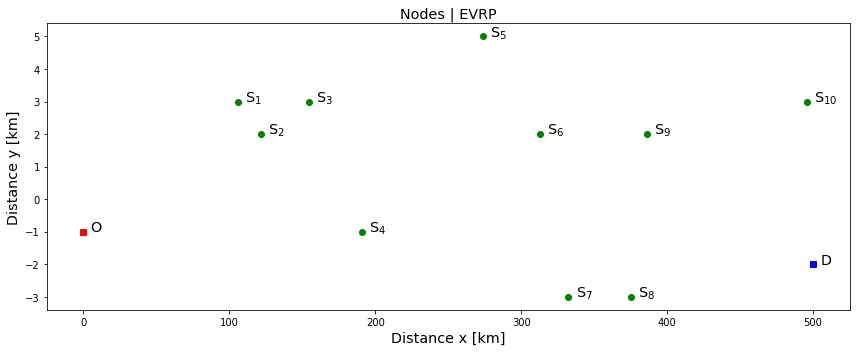

In [4]:
n_cs = 10 # number of charge stations
stations = [n+1 for n in range(n_cs)] #cs vertices
start = 0
nodes = [start]+stations
destination = len(nodes)
nodes.append(destination) # append destination vertex to vertices

Q = 28 # EV Battery capacity kWh
EC = 0.15 # Energy consumption kWh/km
speed = 110 # km/h

X = 500 # total route length in km

# Create coordinates:
rnd = np.random
rnd.seed(42)
loc_x = np.sort([0]+[rnd.randint(0,X)+rnd.rand()*5 for n in range(n_cs)]+[X]).round(1)
loc_y = np.round([rnd.rand()*5*(1-2*rnd.randint(0,2)) for n in range(len(nodes))])

#plot nodes
plt.figure(figsize=(12,5))
plt.plot(loc_x[stations], loc_y[stations], 'o', color='green')
plt.plot(loc_x[0], loc_y[0], 'o', marker='s',color='red')
plt.plot(loc_x[destination], loc_y[destination], 'o', marker='s',c='blue')
for i in stations:
    plt.annotate(r'S$_{{{}}}$'.format(i), (loc_x[i]+5, loc_y[i]), fontsize='x-large')
plt.annotate('O', (loc_x[0]+5, loc_y[0]), fontsize='x-large')
plt.annotate('D', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')
plt.xlabel('Distance x [km]', fontsize='x-large')
plt.ylabel('Distance y [km]', fontsize='x-large')
plt.title('Nodes | EVRP', fontsize='x-large')
plt.tight_layout()

In [5]:
distance_matrix = [[round(np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])),1) if i!=j and i<j else '' for j in nodes] 
                     for i in nodes]
                    
cols = ['O']+['S{}'.format(i) for i in stations]+['D']
dm = pd.DataFrame(distance_matrix, columns=cols, index=cols)
print('+'*50)
print('Distance Matrix [km]')
print('='*50)
dm

++++++++++++++++++++++++++++++++++++++++++++++++++
Distance Matrix [km]


O     S1     S2     S3    S4     S5     S6     S7     S8     S9    S10  \
O      106.1  121.8  154.4   191  273.8  312.8  332.3    375  385.9  495.7   
S1             15.8   48.3  85.1  167.7  206.8  226.4  269.1  279.9  389.7   
S2                    32.5  69.3  151.9    191  210.6  253.2  264.1  373.9   
S3                          36.9  119.4  158.5  178.1  220.8  231.6  341.4   
S4                                 82.9  121.8  141.3    184  194.9  304.7   
S5                                        39.2   59.1  101.6  112.2    222   
S6                                               20.1   62.4   73.1  182.9   
S7                                                      42.7   53.8  163.5   
S8                                                               12  120.8   
S9                                                                   109.8   
S10                                                                          
D                                                                            

         D  
O      500  
S1     394  
S2   378.2  
S3   345.7  
S4     309  
S5   226.4  
S6   187.2  
S7   167.7  
S8     125  
S9   114.2  
S10    6.6  
D

In [6]:
time_matrix = [[round(np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j]))*60/speed, 1) if i!=j and i<j else '' for j in nodes] 
                     for i in nodes]
                    
tm = pd.DataFrame(time_matrix, columns=cols, index=cols)
print('+'*50)
print('Time Matrix [min]')
print('='*50)
tm

++++++++++++++++++++++++++++++++++++++++++++++++++
Time Matrix [min]


O    S1    S2    S3     S4     S5     S6     S7     S8     S9    S10  \
O      57.9  66.5  84.2  104.2  149.3  170.6  181.3  204.5  210.5  270.4   
S1            8.6  26.3   46.4   91.5  112.8  123.5  146.8  152.7  212.6   
S2                 17.7   37.8   82.9  104.2  114.9  138.1  144.1  203.9   
S3                        20.1   65.1   86.5   97.1  120.4  126.3  186.2   
S4                               45.2   66.5   77.1  100.4  106.3  166.2   
S5                                      21.4   32.3   55.4   61.2  121.1   
S6                                               11     34   39.9   99.8   
S7                                                    23.3   29.4   89.2   
S8                                                            6.5   65.9   
S9                                                                  59.9   
S10                                                                        
D                                                                          

         D  
O    272.7  
S1   214.9  
S2   206.3  
S3   188.6  
S4   168.5  
S5   123.5  
S6   102.1  
S7    91.5  
S8    68.2  
S9    62.3  
S10    3.6  
D

In [7]:
consumption_matrix = [[round(np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j]))*EC, 1) if i!=j and i<j else '' for j in nodes] 
                     for i in nodes]
                    
cm = pd.DataFrame(consumption_matrix, columns=cols, index=cols)
print('+'*50)
print('Consumption Matrix [kWh]')
print('='*50)
cm

++++++++++++++++++++++++++++++++++++++++++++++++++
Consumption Matrix [kWh]


O    S1    S2    S3    S4    S5    S6    S7    S8    S9   S10     D
O      15.9  18.3  23.2  28.6  41.1  46.9  49.8  56.3  57.9  74.4    75
S1            2.4   7.2  12.8  25.2    31    34  40.4    42  58.5  59.1
S2                  4.9  10.4  22.8  28.6  31.6    38  39.6  56.1  56.7
S3                        5.5  17.9  23.8  26.7  33.1  34.7  51.2  51.9
S4                             12.4  18.3  21.2  27.6  29.2  45.7  46.4
S5                                    5.9   8.9  15.2  16.8  33.3    34
S6                                            3   9.4    11  27.4  28.1
S7                                                6.4   8.1  24.5  25.2
S8                                                      1.8  18.1  18.8
S9                                                           16.5  17.1
S10                                                                   1
D

Lets now formulate and instatiate the EVRP model using CPLEX.

In [8]:
arcs = {(i,j) for i in nodes for j in nodes if i!=j and i<j} # i<j ensures we go from start to end, no return
distances = {(i,j):np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j])) for j in nodes 
                     for i in nodes} 

times = {arc:distances.get(arc)*60/speed for arc in arcs}
consumption = {arc:EC*distances.get(arc) for arc in arcs}

mdl=Model('EVRP')

### decision variables flow graph ###

# boolean variable used to activate an arc
x=mdl.binary_var_dict(arcs,name='x')

# defines the quantity that flows through the arc (energy consummed during the drive from i to j) 
#capacity constraints: arc will be not used if q is larger than Q (if E consumption > than Battery capacity)
q = mdl.continuous_var_dict(arcs, ub=Q, name = 'q')

### Objective function: ###
# minimize the travel time
mdl.minimize(mdl.sum(times[i,j]*x[i,j] for i,j in arcs))
#mdl.minimize(mdl.sum(times[i,j]*x[i,j] for i,j in arcs) + overhead*(mdl.sum(x[i,j] for i,j in arcs) - 1))

### constraints ###

# if x[i,j] -> q[i,j] (flow quantity) == energy consumption of the arc 
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],q[i,j]==consumption[i,j]) for i,j in arcs)

# forces flow from starting point
mdl.add_constraint(mdl.sum(x[0,j] for j in nodes if j !=0) == 1 )

# flow constraint
for i in nodes:
    mdl.add_constraint(mdl.sum(x[j,i] for j in nodes if i!=j and i>j) == 
                       mdl.sum(x[i,j] for j in nodes if i!=j and i<j),'flow{}'.format(i) )

# deletes constraint that is not required and blocks the flow
for i in nodes:
    if i not in stations:
        mdl.remove_constraint('flow{}'.format(i))

# print model
print(mdl.print_information())

Model: EVRP
 - number of variables: 132
   - binary=66, integer=0, continuous=66
 - number of constraints: 77
   - linear=11, indicator=66
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
None


As shown above, our model has 132 variables and 77 constraints. We now, solve the problem and plot the solution.

JobSolveStatus.OPTIMAL_SOLUTION
solution for: EVRP
objective: 272.812
x_3_7 = 1
x_0_3 = 1
x_7_11 = 1
q_3_7 = 26.715
q_0_3 = 23.153
q_7_11 = 25.155
None
Total Distance traveled: 500.2 km


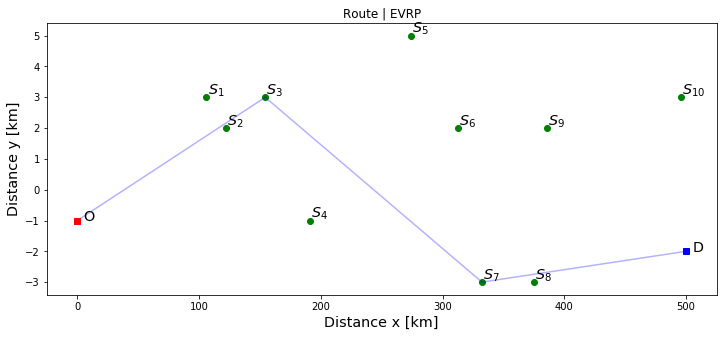

In [9]:
# Solve model
solution=mdl.solve()#log_output=True)
print(mdl.get_solve_status())
print(solution.display())

def plotSolution():
    arcos_activos=[k for k in arcs if x[k].solution_value>0.9]
    
    plt.figure(figsize=(12,5))
    plt.scatter(loc_x,loc_y,color="green")

    for i in stations:
        plt.annotate('$S_{{{}}}$'.format(i),(loc_x[i]+1,loc_y[i]+0.1), fontsize='x-large')

    for i,j in arcos_activos:
        plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],color="blue",alpha=0.3)

    plt.plot(loc_x[start],loc_y[start],color='red',marker='s')
    plt.annotate('O', (loc_x[start]+5, loc_y[start]), fontsize='x-large')
    plt.plot(loc_x[destination], loc_y[destination], color='blue', marker='s')
    plt.annotate('D', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.ylabel("Distance y [km]", fontsize='x-large')
    plt.title("Route | EVRP")
    
    tot_dis = sum(distances[arc] for arc in arcos_activos )
    print('Total Distance traveled: {:.1f} km'.format(tot_dis))
    
plotSolution()


As shown above, the solution is optimal and we get an minimized objective value of 272.812 minutes (4.5 h). By printing the solution we get that variables $x_{0~3}$, $x_{3~7}$ and $x_{7~11}$ are all equal to 1 (nodes 0 and 11 correspond to $O$ and $D$ respectively). This means that these are the active arcs of the solution. Also the $q_{ij}$ for these arcs are printed and refer, as early mentioned, to the consumed energy when traveling  from $i$ to $j$. Note that this energy is always lower or equal to $Q=28$ kWh (the EV battery capacity), arcs with larger energy consumption are not energetically feasible. Such arcs where not allowed by the imposed constraints. 

Therefore, in this solution, by driving the following route $O \to S_3 \to S_7\to D$, we reach our destination in the shortest time. 

#### Charging Time

Lets try now to remove the homogeneity of the charging stations by randomly adding different charging times $t_C$ to them. To do so, we will define three different charging times as follows:

code | Time (min) 
---- | --------- 
0    | 120 min (slow)
1    | 90 min (medium)
2    | 60 min (fast)

The charging time will be distributed so that 50% of the total stations are slow chargers, 30% medium and the rest 20% fast chargers.

On top of that we will add 10 minutes overhead time to account for the time needed to drive through the charge station, plug the charger, etc. 

We also need to modify the objective function to reduce the charging time. The objective function will now look like this:

$$
\text{Min}~ Z = \sum_{i \in A}\sum_{j \in A} x_{ij}t_{ij}+ \sum_{i \in S}  x_{ij}(t_{C~i} + \text{overhead time})
$$


JobSolveStatus.OPTIMAL_SOLUTION
solution for: EVRP
objective: 512.791
x_4_8 = 1
x_2_4 = 1
x_8_11 = 1
x_0_2 = 1
q_4_8 = 27.602
q_2_4 = 10.390
q_8_11 = 18.751
q_0_2 = 18.276
None
Total Distance traveled: 500.1 km
Total Route Time: 512.8 min
Drive Time: 272.8 min
Charging Time: 240.0 min


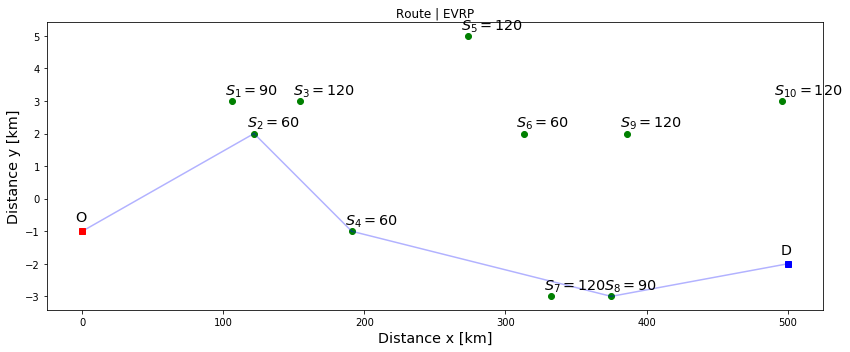

In [10]:
def solveSTimes(seed):
    # add charge point times (slow: 120 min, medium:90min, fast:60min)
    station_speeds = {}
    for i in stations:
        rnd.seed(i+seed)
        p =rnd.rand()
        if p > 0 and p < .5:
            s = 120
        elif p > .5 and p < .8:
            s=90
        else:
            s= 60
        station_speeds[i] = s

    overhead = 10 # minutes

    # objective function
    mdl.minimize(mdl.sum(times[i,j]*x[i,j] for i,j in arcs) + 
                 overhead*(mdl.sum(x[i,j] for i,j in arcs) - 1) +
                mdl.sum(x[i,j]*station_speeds[j] for i,j in arcs if j!=destination))

    # Solve model
    solution=mdl.solve()#log_output=True)
    print(mdl.get_solve_status())

    print(solution.display())


    arcos_activos=[k for k in arcs if x[k].solution_value>0.9]

    plt.figure(figsize=(12,5))
    plt.scatter(loc_x,loc_y,color="green")

    for i in stations:
        plt.annotate('$S_{{{}}}={}$'.format(i,station_speeds[i]),(loc_x[i]-5,loc_y[i]+0.2), fontsize='x-large')

    for i,j in arcos_activos:
        plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],color="blue",alpha=0.3)

    plt.plot(loc_x[start],loc_y[start],color='red',marker='s')
    plt.annotate('O', (loc_x[start]-5, loc_y[start]+0.3), fontsize='x-large')
    plt.plot(loc_x[destination], loc_y[destination], color='blue', marker='s')
    plt.annotate('D', (loc_x[destination]-5, loc_y[destination]+0.3), fontsize='x-large')

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.ylabel("Distance y [km]", fontsize='x-large')
    plt.title("Route | EVRP")
    plt.tight_layout()
    
    tot_dis = sum(distances[arc] for arc in arcos_activos )
    print('Total Distance traveled: {:.1f} km'.format(tot_dis))
    
    driveTime = sum([times[arc] for arc in arcos_activos])
    chargeTime = mdl.objective_value -driveTime

    print('Total Route Time: {:.1f} min\nDrive Time: {:.1f} min\nCharging Time: {:.1f} min'.format(mdl.objective_value, driveTime,chargeTime))

solveSTimes(2)

In the figure above, the number next to the station number refers to its charging time. As observed, the algorithm chooses the best ombination of Charge columns that bring us to $D$ in the shortest time. Here for instance we avoid all possible slow chargers ($t_C=120$ min) since charging at these stations will dramatically increase the total route time. The best route under these circumstances is $O \to S_2 \to S_4\to S_8\to D$. The total time is 512.8 min (8.5 h).

Note also, that in comparison to the previous example where no charging time was considered, here we might need to do more stops if that will make the total route time shortest. One might drive farthest and make just one or two stops, but you might need to wait longer for charging, which makes it not an optimal solution. 

Lets check what happens when we randomly change once more the charging time at charging columns.

JobSolveStatus.OPTIMAL_SOLUTION
solution for: EVRP
objective: 482.949
x_5_8 = 1
x_1_5 = 1
x_8_11 = 1
x_0_1 = 1
q_5_8 = 15.242
q_1_5 = 25.157
q_8_11 = 18.751
q_0_1 = 15.911
None
Total Distance traveled: 500.4 km
Total Route Time: 482.9 min
Drive Time: 272.9 min
Charging Time: 210.0 min


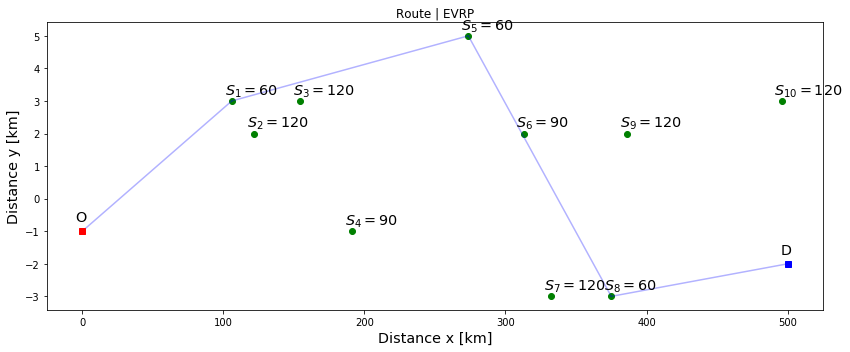

In [11]:
solveSTimes(24)

Once more we see that the algorithm selects the charge stations that makes the whole route shortest in time.

Lets move on an improve our model by adding battery charge curves.

### Adding Charging Curves

In reality, charging time at a charging column is not a constant, it is a function of the charging power of the column and is depending on the battery properties of the EV. Each EV has a characteristic charging curve, which means also that charging time at the same charging column is different for different EV models. Moreover, charging curves are also affected by external conditions like outside temperature and battery temperature. 

This piece of information is extremely important if one want to make a serious time optimization of the desired route. Hence, we need to implement this in our MILP model. However, there is a complication, as earlier mentioned, MILP works only when we can model our problem in terms of linear constraints and functions, charging curves, on the contrary, are not linear functions, so what can we do?

There is a solution for this issue and it is to approximate the charging curve using a Piecewise linear function. A piecewise function is a function that is defined on a sequence of intervals. This is, we subdivide the original function (charging curve) into subintervals and fit a linear function at this intervals. In this way we get a linear function for each interval of the curve.

Lets see an example using real data from a Hyundai Ioniq charge curve.

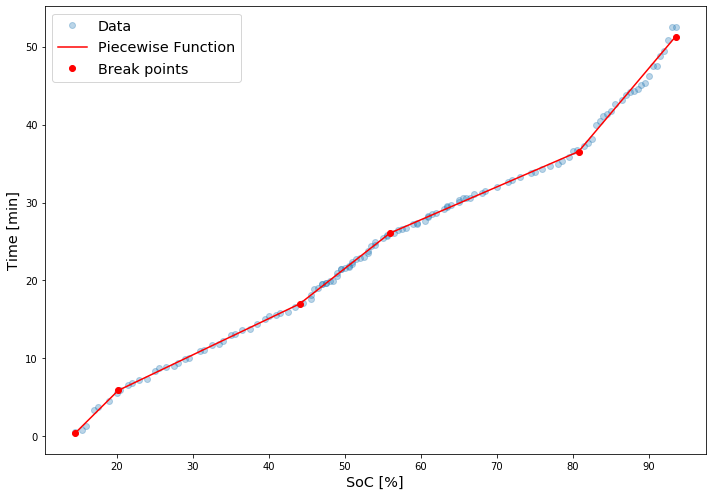

In [12]:
import datetime, sys, datetime, warnings
sys.path.append('../chargecurve/')
warnings.filterwarnings('ignore')

from databases import load_base2_ftp, query_station
from chargecurve import AutoCharge, ChargingCurve
from functions import get_peaks, collect_charges
from plot import charges, chargecurvestation, fullchargecurve
import pwlf

hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,1))

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

# collect charging data as AutoCharge objects
hyundai_charges = collect_charges(hyundai[mask], peaks_id)

# getcharging curves
HyundaiCharges = ChargingCurve(hyundai_charges)
#HyundaiCharges.data.chargepoint_id.unique()

# select charging curve for CP = 95195
data = HyundaiCharges.ChargePointCurve(95195, battCapacity=28)

Y = data.dropna().elapsedTime.values
X = data.dropna().soc_display.values

# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(X, Y)

# fit the data for 5 line segments
res = my_pwlf.fit(5)

# predict for the determined points
xHat = np.linspace(min(X), max(X), num=len(X))
yHat = my_pwlf.predict(xHat)

# plot the results
plt.figure(figsize=(10,7))
plt.plot(X, Y, 'o', alpha =0.3, label = 'Data')
plt.plot(xHat, yHat, c='red', label = 'Piecewise Function')
plt.plot(my_pwlf.fit_breaks,my_pwlf.predict(my_pwlf.fit_breaks), 'o',  c='red', label = 'Break points')
plt.ylabel('Time [min]', fontsize='x-large')
plt.xlabel('SoC [%]', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.tight_layout()


This for instance is the SoC vs. Charging time curve of a Hyundai Ioniq for a 50 kW charging column. The blue dots are the real data, whereas the red line shows the Piecewise linear approximation. As observed, the Piecewise function reproduces fairly well the real data. The red points show the break points, which define the limits of the linear sub-regions of the Piecewise function. 

For our final example, we will implement three different charging curves with Piecewise functions to model the case where we have three different types of chargers. In a real life example it would be as having, for example, CCS, Type2 and different Charger powers. 

Below are shown the charging curves that will be used for this example. These curves are designed so that they charge with a given constant speed from 0 to 70% SoC and after that the charging speed decreases (it takes more time to charge), in a way which is similar to real conditions.

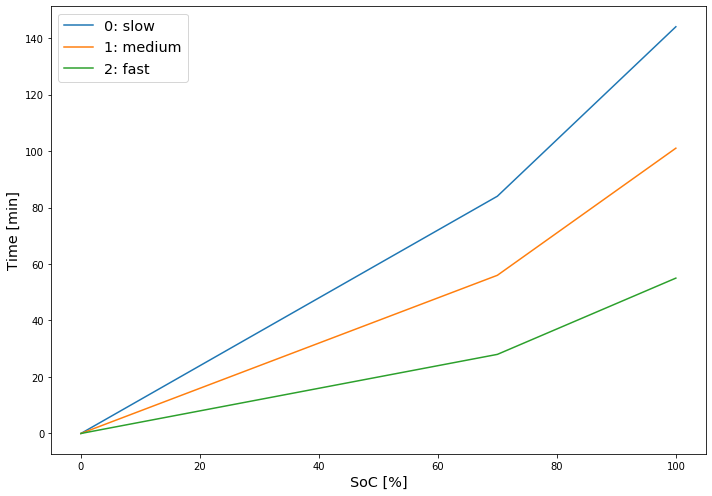

In [13]:
x = np.arange(0,101,1)
y = lambda x, b1, b2: b1*x if x<70 else b2*x - 70*(b2 - b1)

plt.figure(figsize=(10,7))
plt.plot(x, [y(i,1.2,2) for i in x], label = '0: slow')
plt.plot(x, [y(i,0.8,1.5) for i in x], label = '1: medium')
plt.plot(x, [y(i,0.4,0.9) for i in x], label = '2: fast')
plt.xlabel('SoC [%]',fontsize='x-large')
plt.ylabel('Time [min]',fontsize='x-large')
plt.legend(fontsize='x-large')
plt.tight_layout()

Alright, now, in order to use the Piecewise functions we will need to add couple of more decision variables to the model. These are, the EV battery charge when the EV enters a charging station ($C_{IN}$) and the charge state when it leaves the charge station ($C_{OUT}$). With these we can calculate the time spent during the charge $\Delta t_C = t_{C~OUT}-t_{C~IN}$. Where $t_C = f_{S}(C)$ and $f_{S}(C)$ is the Piecewise function at station $S$.

Under these conditions our objective function looks like this:

$$
\text{Min}~ Z = \sum_{i \in A}\sum_{j \in A} x_{ij}t_{ij}+ \sum_{i \in S} x_{ij}(\Delta t_{C~i} + \text{overhead time})
$$

Subject to the following new constraints:

+ The amount of charged energy at the column $i$ will be that just enough to reach the next Node $j$, not more.

$$ C_{OUT~i}-C_{IN~j} = q_{ij}~ i,j \in A: i<j $$

We can also define some initial, safety and final condition constraints:

+ Since SoC at the beginning of the route is not always 100% we can define an initial charge level at node $O$: 

$$ C_{OUT~O} = Q\cdot SoC_{ini} $$


+ We don't want to reach $D$ with an empty tank! Hence, we can define a desired final charge level at node $D$: 

$$ C_{IN~D} \geq Q\cdot SoC_{end} $$


+ For safety precaution in case plans change or there are problems we can define also a minimum charge level when arriving at charging stations: 

$$ C_{IN~j} \geq Q\cdot SoC_{min} $$

In the cell below we will write the complete model using CPLEX.

In [14]:
def solveEVRP(seed, soc_ini, soc_min, soc_end):
    
    overhead = 10 # mins
    
    # random assignation of charge cuves to charge stations
    station_charge_curves = {}
    for i in stations:
        rnd.seed(i+seed)
        p =rnd.rand()
        if p > 0 and p < .5:
            s = 0
        elif p > .5 and p < .8:
            s=1
        else:
            s= 2
        station_charge_curves[i] = s

    mdl=Model('EVRP')

    # decision variables flow graph

    # boolean variable used to activate an arc
    x=mdl.binary_var_dict(arcs,name='x')

    # defines battery state of charge at nodes
    c_in = mdl.continuous_var_dict(stations+[destination], lb=Q*soc_min, name = 'c_in')
    c_out = mdl.continuous_var_dict([start]+stations, lb=Q*soc_min,  name = 'c_out')

    # defines charging times at stations
    tci = mdl.continuous_var_dict(stations, name = 'tci')
    tcf = mdl.continuous_var_dict(stations, name = 'tcf')

    # defines the quantity that flows through the arc (energy consummed during the drive from i to j) 
    q = mdl.continuous_var_dict(arcs, ub=Q*(1-soc_min), name = 'q')

    # objective function: minimize the travel time
    mdl.minimize(mdl.sum(times[i,j]*x[i,j] for i,j in arcs) 
                 + overhead*(mdl.sum(x[i,j] for i,j in arcs) - 1) 
                 + mdl.sum((tcf[j]-tci[j] )  for j in stations) 
                )

    # constraints

    # if x[i,j] -> defines the value if q[i,j] (flow quantity) to be equal to the engy consumtion of the arc 
    mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],q[i,j]==consumption[i,j]) for i,j in arcs)


    #battery charge constraints: 
    mdl.add_indicator_constraints(mdl.indicator_constraint(x[i,j],c_out[i]-c_in[j]==q[i,j]) 
                                  for i,j in arcs )

    mdl.add_constraint(c_out[start]==Q*soc_ini)
    mdl.add_constraint(c_in[destination]==Q*soc_end)

    # charger time

    # define Piecewise parameters for the different charging curves
    pw_slow_params=[0]+[[(x, y(x,1.2,2)) for x in [0,70]]] + [2]
    pw_medium_params=[0]+[[(x, y(x,0.8,1.5)) for x in [0,70]]] + [1.5]
    pw_fast_params=[0]+[[(x, y(x,0.4,0.9)) for x in [0,70]]] + [0.9]
    
    slow_pwf = mdl.piecewise(*pw_slow_params)
    medium_pwf = mdl.piecewise(*pw_medium_params)
    fast_pwf = mdl.piecewise(*pw_fast_params)

    curves = [slow_pwf, medium_pwf, fast_pwf]

    # charge time as normal constrain
    mdl.add_constraints(tci[j] == curves[station_charge_curves[j]](c_in[j]*100/Q)
                        for j in stations)

    mdl.add_constraints(tcf[j] == curves[station_charge_curves[j]](c_out[j]*100/Q)
                        for j in stations)

    mdl.add_constraints(tcf[j] >= tci[j] for j in stations)


    # forces flow from starting point
    mdl.add_constraint(mdl.sum(x[0,j] for j in nodes if j !=0) == 1 )

    # flow constraint
    for i in nodes:
        mdl.add_constraint(mdl.sum(x[j,i] for j in nodes if i!=j and i>j) == 
                           mdl.sum(x[i,j] for j in nodes if i!=j and i<j),'flow{}'.format(i) )

    # deletes constraint that is no required and blocks the flow
    for i in nodes:
        if i not in stations:
            mdl.remove_constraint('flow{}'.format(i))

    # print model
    #print(mdl.export_to_string())
    #print(mdl.print_information())

    # Solve model
    solucion=mdl.solve()#log_output=True)
    print(mdl.get_solve_status())

    #print(solucion.display())

    arcos_activos=[k for k in arcs if x[k].solution_value>0.9]

    plt.figure(figsize=(12,5))
    plt.scatter(loc_x,loc_y,color="green")

    for i in stations:
        plt.annotate('$S_{{{}}}={}$'.format(i,station_charge_curves[i]),(loc_x[i]-5,loc_y[i]+0.2), fontsize='x-large')

    for i,j in arcos_activos:
        plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],color="blue",alpha=0.3)

    plt.plot(loc_x[start],loc_y[start],color='red',marker='s')
    plt.annotate('O', (loc_x[start]+5, loc_y[start]), fontsize='x-large')
    plt.plot(loc_x[destination], loc_y[destination], color='blue', marker='s')
    plt.annotate('D', (loc_x[destination]+5, loc_y[destination]), fontsize='x-large')

    plt.xlabel("Distance x [km]", fontsize='x-large')
    plt.ylabel("Distance y [km]", fontsize='x-large')
    plt.title("Route | EVRP")

    charger_dic ={0: 'Slow', 1:'Medium', 2:'Fast'}
    #check times
    print('+'*50)
    print('Station\tCharger\tBattery in\tBattery out \tCharge Time')
    print('\t\t[kWh]\t\t[kWh]\t\t[min]')
    print('='*50)
    print('{}\t{}\t{}\t\t{:.1f} ({:.1f}%)\t\t{}'.format(start, '','',  c_out[start].solution_value,c_out[start].solution_value*100/Q, '') )
    for sol in tcf:
        tf =tcf[sol].solution_value
        ti = tci[sol].solution_value
        delta = tf-ti
        ci = c_in[sol].solution_value
        co = c_out[sol].solution_value
        ctype = charger_dic[station_charge_curves[sol]]
        if delta !=0:
            print('{}\t{}\t{:.1f} ({:.1f}%)\t{:.1f} ({:.1f}%)\t{:.1f}'.format(sol,ctype, ci, ci*100/Q, co, co*100/Q, delta) )
    print('{}\t\t{:.1f} ({:.1f}%)\t{}\t{}'.format(destination, c_in[destination].solution_value, c_in[destination].solution_value*100/Q, '', '') )
    print('+'*50)

    tot_dis = sum(distances[arc] for arc in arcos_activos )
    print('Total Distance traveled: {:.1f} km'.format(tot_dis))
    
    chargeTime = sum([tcf[sol].solution_value - tci[sol].solution_value for sol in tcf]) + (len(arcos_activos)-1)*10
    driveTime = sum([times[arc] for arc in arcos_activos])
    #chargeTime = mdl.objective_value -driveTime

    print('Total Route Time: {:.1f} min ({:.1f} h)\nDrive Time: {:.1f} min ({:.1f} h)\nCharging Time: {:.1f} min ({:.1f} h)'.format(mdl.objective_value, mdl.objective_value/60, driveTime,driveTime/60,chargeTime, chargeTime/60))

Now, we will solve a model case where we leave $O$ with full charge, will constraint our EV battery charge to have not less than 10% when it arrives at a charge column. Finally, the EV should arrive in $D$ with 20% battery charge.

JobSolveStatus.OPTIMAL_SOLUTION
++++++++++++++++++++++++++++++++++++++++++++++++++
Station	Charger	Battery in	Battery out 	Charge Time
		[kWh]		[kWh]		[min]
0				28.0 (100.0%)		
3	Fast	4.8 (17.3%)	20.7 (74.0%)	24.7
5	Medium	2.8 (10.0%)	19.6 (70.1%)	48.2
9	Medium	2.8 (10.0%)	19.3 (68.8%)	47.1
10	Fast	2.8 (10.0%)	6.6 (23.5%)	5.4
11		5.6 (20.0%)		
++++++++++++++++++++++++++++++++++++++++++++++++++
Total Distance traveled: 502.4 km
Total Route Time: 439.4 min (7.3 h)
Drive Time: 274.0 min (4.6 h)
Charging Time: 165.3 min (2.8 h)


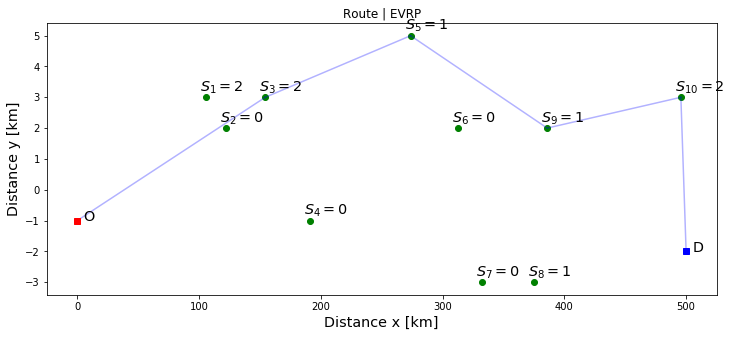

In [15]:
solveEVRP(seed=5, soc_ini=1, soc_min=0.1, soc_end=0.2)

As we observe from the table, EV leaves $O$ with 100% charge and arrives at $D$ with 20% SoC as desired. Also, we always arrive at charge columns with a SoC larger or equal to 10%. When we look at which type of chargers the algorithm uses, are mostly fast or medium chargers. Moreover, it does not fully charge the battery, since due to the optimization constraints, we asked the algorithm to charge just enough energy to reach the next feasible node. 
Another very important observation, is that the EV charges at SoC levels, not much larger than 70%, this is because, the charging curves become slower after this and it will take more time. For example, at $S_9$ the EV was charged to 68.8%, one could have charge a bit longer up to 81%. Like this it would arrive at $D$ with 20% charge as desired, however, this additional 12% charge in a medium charger takes much more time since above 70% SoC, the charge curve slope is steeper. The algorithm finds more efficient to stop charging at 68.8% and then travel to $S_{10}$ which charges faster and reduces the overall route time, even though it might make the  route few kilometers longer.

Lets try another model case, where we keep all conditions the same, but we depart $O$ with 70% and arrive at $D$ with 10% SoC.

JobSolveStatus.OPTIMAL_SOLUTION
++++++++++++++++++++++++++++++++++++++++++++++++++
Station	Charger	Battery in	Battery out 	Charge Time
		[kWh]		[kWh]		[min]
0				19.6 (70.0%)		
1	Fast	3.7 (13.2%)	19.6 (70.0%)	22.7
3	Fast	12.4 (44.1%)	20.7 (74.0%)	13.9
5	Medium	2.8 (10.0%)	19.6 (70.1%)	48.2
9	Medium	2.8 (10.0%)	19.9 (71.2%)	49.7
11		2.8 (10.0%)		
++++++++++++++++++++++++++++++++++++++++++++++++++
Total Distance traveled: 500.2 km
Total Route Time: 447.4 min (7.5 h)
Drive Time: 272.8 min (4.5 h)
Charging Time: 174.6 min (2.9 h)


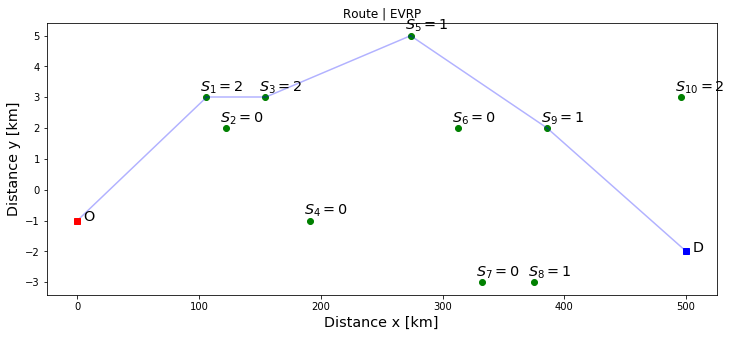

In [16]:
solveEVRP(seed=5, soc_ini=0.7, soc_min=0.1, soc_end=0.1)

In this case, the EV needs to make an earlier stop at $S_1$ and chargers its battery to 70% SoC. Then it travels 16 Km from $S_1$ to $S_3$, arrives with 44.1% SoC and tops up to 74% for a 13.9 minute charge. Notice here, that the algorithm finds more efficient to drive some few kilometers consuming only 30% of the battery and then charge back this 30% before moving towards $S_5$. 

Here is actually very nice demonstrated how the algorithm "intelligence" takes the best decisions to reduce the overall route time.

Lets check another case, where we keep this conditions of initial and final charge, but shuffle once more the charging speeds of the charge columns. 

JobSolveStatus.OPTIMAL_SOLUTION
++++++++++++++++++++++++++++++++++++++++++++++++++
Station	Charger	Battery in	Battery out 	Charge Time
		[kWh]		[kWh]		[min]
0				19.6 (70.0%)		
1	Slow	3.7 (13.2%)	10.0 (35.9%)	27.2
3	Fast	2.8 (10.0%)	20.7 (74.0%)	27.6
5	Fast	2.8 (10.0%)	19.6 (70.0%)	24.0
7	Fast	10.7 (38.3%)	28.0 (99.8%)	39.5
11		2.8 (10.0%)		
++++++++++++++++++++++++++++++++++++++++++++++++++
Total Distance traveled: 500.6 km
Total Route Time: 431.4 min (7.2 h)
Drive Time: 273.1 min (4.6 h)
Charging Time: 158.3 min (2.6 h)


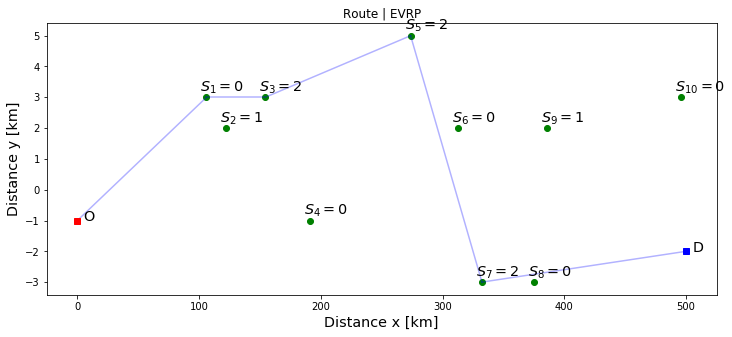

In [17]:
solveEVRP(seed=1, soc_ini=0.7, soc_min=0.1, soc_end=0.1)

Here, we depart $O$ again with 70% SoC and the EV is forced to make a charging stop at $S_1$, a slow charger. Due to its battery level at $O$ (19.6 kWh - 70%) it can not reach $S_2$ which is actually a faster charger. To reach $S_2$ the EV needs 18.2 kWh, but would arrive with a SoC smaller than 10% which is a constraint we imposed for safety reasons. Nevertheless, the algorithm charges only 6.3 kWh for about 27.2 min, which gives the EV just enough energy to reach $S_3$ which is a fast charger. From there, it just uses fasts chargers, which reduces the total charging time. Also, we can see that at $S_7$ it fully charges the battery so it can arrive at $D$ with the 10% battery we asked for.

## CPLEX Limitations

CPLEX is a commercial optimization API developed by IBM, the free version of it allows to use models with up to 1000 variables and 1000 constraints. For the actual model of our EVRP the number of variables and constraints scale with the number of charging stations as follows:

+ Variables:

$$ \text{Vars} = 2\times(\text{Arcs} + 4\times\text{Stations} +1)$$

+ Constraints:

$$ \text{Const} = 2\times\text{Arcs} + 3\times(2\times\text{Stations} +1)$$

That means, that by solving a model with 27 charging stations, we are exceeding the allow limit of the free version. For unlimited use of variables and constraints we would need to pay (check [here](https://www.ibm.com/de-de/products/ilog-cplex-optimization-studio/pricing) for more details). 

Another possibility is to reduce the amount of arcs of the graph, for example by removing unfeasible arcs, i.e., arcs with energy consumption larger than the EV battery.

Below is the energy consumption matrix for the model we have been considering so far after removing unfeasible arcs. As one can see, since the number of variables and constraints depends also on how many arcs we cosider, we can extend the amount of charge stations we can use. By doing this, the number of arcs was reduced from 66 to 36.

In [18]:
consumption_matrix = [[round(np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j]))*EC, 1) 
                       if i!=j and i<j and np.hypot((loc_x[i]-loc_x[j]),(loc_y[i]-loc_y[j]))*EC < Q
                       else '' for j in nodes] 
                     for i in nodes]
                    
cm = pd.DataFrame(consumption_matrix, columns=cols, index=cols)
print('+'*50)
print('Consumption Matrix [kWh]')
print('='*50)
cm

++++++++++++++++++++++++++++++++++++++++++++++++++
Consumption Matrix [kWh]


O    S1    S2    S3    S4    S5    S6    S7    S8    S9   S10     D
O      15.9  18.3  23.2                                                
S1            2.4   7.2  12.8  25.2                                    
S2                  4.9  10.4  22.8                                    
S3                        5.5  17.9  23.8  26.7                        
S4                             12.4  18.3  21.2  27.6                  
S5                                    5.9   8.9  15.2  16.8            
S6                                            3   9.4    11  27.4      
S7                                                6.4   8.1  24.5  25.2
S8                                                      1.8  18.1  18.8
S9                                                           16.5  17.1
S10                                                                   1
D

Other solution is to use another free API like OR-Tools from Google, however, the documentation is not good, and it might take some time until one finds out how to implement such model using this API.

## Possible Implementation

In order to implement this solution for the EVRP the following steps are proposed:

1. Determine the route from $O$ to $D$.
2. Find the charging columns along the route.
3. Filter the charging columns to those which are compatible to the EV.
4. Do a further filtering based on other constraints, for instance, a minimum Charger Power, remove not working chargers, give preference to stations where there are more columns (higher availability probability), etc.
5. Build the distance, time and consumption matrices. 
    + Calculation of the consumption to be used in the consumption matrix is done as described [here.](https://eclever.atlassian.net/wiki/spaces/ROUTE/pages/1193639941/Optimum+Route+Velocity+Charge+Stops+and+Overall+Route+Time+Estimation)
6. Filter out unfeasible arcs from the model
7. Solve the EVRP
8. Give solution to user.


## Summary

In this notebook we have define the Electric Vehicle Routing Problem, were we aim to travel from an origin location to a final destination charging along the route in a way that the total route time is the shortest. Using mathematical graph theory and formulating the problem as a Mixed Integer Linear Program and approximating EV battery charging curves with Piecewise linear functions, we were able to solve this combinatory problem using the CPLEX optimization library. 

The developed algorithm optimized the decision of which charge columns to use, and how much energy to charge so that the EV arrives to its final destination with the desired amount of remaining battery SoC and in the shortest time possible.

Modeling of EVRP problems can be extended not only to one EV but also to problems where more vehicles are used, like in fleets with several EVs where they need to deliver or pick up things and have demand and supply constraints, etc.

## References

This work was mostly inspired by the work of A. Montoya et al. 

1. Montoya, A. et al., The electric vehicle routing problem with nonlinear charging function Transportation Research Part B: Methodological, 2017, 103, 87-110.

2. Montoya, A. Electric Vehicle Routing Problems : models and solution approaches. Université d’Angers, PhD Thesis, 2016 


In [19]:
def getVars(stations, arcs=False):
    if arcs:
        arcs = arcs
    else:
        arcs = len([(i,j) for i in range(stations+2) for j in range(stations+2) if i!=j and i<j])
    vars_ = 2*(arcs + 4*stations +1) 
    cons = arcs*2 + 3 + 6*stations 
    print('Stations:', stations,', Variables:', vars_,', Constraints:', cons)
getVars(10), getVars(10,36)

len(arcs), (len(stations)+2)/2*((len(stations)+2) - 1) 

Stations: 10 , Variables: 214 , Constraints: 195
Stations: 10 , Variables: 154 , Constraints: 135


(66, 66.0)

# Add charging curves in ChargeCurve class

In [20]:
#for n in range(len(my_pwlf.fit_breaks)):
   # print('slopes: {:.1f}, breakpoint: {:.1f}'.format(my_pwlf.slopes[n], my_pwlf.fit_breaks[n]))
_ = [(my_pwlf.fit_breaks[n],my_pwlf.predict(my_pwlf.fit_breaks[n])[0]) for n in range(len(my_pwlf.fit_breaks))]
_ = [my_pwlf.slopes[0]] + [_] + [my_pwlf.slopes[-1]]
_

[0.9685188042499258,
 [(14.5, 0.35861349278100985),
  (20.199568147361294, 5.878752419604335),
  (44.076874862736446, 16.99873912035425),
  (55.928660408030936, 26.063875601828663),
  (80.74128263569608, 36.539829121170364),
  (93.5, 51.293940636117036)],
 1.1563945727197802]

In [21]:
my_pwlf.slopes

array([0.9685188 , 0.46571361, 0.76487517, 0.4222026 , 1.15639457])